In [63]:
import os
import collections
import math
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from typing import Callable
import copy
import json
from tqdm import tqdm
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
ImageFile.LOAD_TRUNCATED_IMAGES = True

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    

data_dir = "~/VisualEmotion/data"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

In [5]:
# Transform
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                    [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                    [0.2023, 0.1994, 0.2010])])

In [6]:
# Sampler
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]
        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
    


In [7]:
# dataset 
train_ds = torchvision.datasets.ImageFolder(data_dir + "/images/train", transform=transform_train)
valid_ds = torchvision.datasets.ImageFolder(data_dir + "/images/valid", transform=transform_train)
test_ds = torchvision.datasets.ImageFolder(data_dir + "/images/test", transform=transform_test)

In [8]:
# dataloader
batch_size=256
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
    sampler=ImbalancedDatasetSampler(train_ds), drop_last=True, num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
    sampler=ImbalancedDatasetSampler(valid_ds), drop_last=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, 
    sampler=ImbalancedDatasetSampler(test_ds), drop_last=False, num_workers=0)


In [9]:
test_ds.class_to_idx

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [25]:
# model setting
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)
model.to(device)
# model = nn.DataParallel(model, device_ids=devices).to(devices[0])

# optimizer
n_epochs, early_stop = 200, 30
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//5, gamma=0.9)

# loss
loss_fn = nn.CrossEntropyLoss()

In [26]:
# train
global_step = -1
loss_log = []
writer = SummaryWriter(log_dir="./log")
def train_epoch(epoch, model, optimizer, scheduler, data_loader, writer, args):

    global global_step, loss_log

    model.train()

    for feat, label in tqdm(data_loader, total=len(data_loader)):
        
        feat, label = feat.to(device), label.to(device)

        global_step += 1
        optimizer.zero_grad()
        
        pred = model(feat)
        loss = loss_fn(pred, label)
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(model.parameters(), 3.)
        optimizer.step()
        
        if writer:
            writer.add_scalar('Train/RunningLoss', loss.item(), global_step)
        else:
            loss_log.append(loss.item()) 
    scheduler.step()
    
    # save log
    if writer:
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
            if param.grad is not None:
                writer.add_histogram(name+'.grad', param.grad, epoch)

                
def test_epoch(epoch, model, data_loader, writer, args, prefix='Test'):

    model.eval()

    losses = []
    scores = []

    for feat, label in tqdm(data_loader, desc=prefix, total=len(data_loader)):

        feat, label=feat.to(device), label.to(device)
        with torch.no_grad():
            pred = model(feat)

        loss = loss_fn(pred, label)
        score = (pred.argmax(dim=1)==label).to(feat).mean()
        
        losses.append(loss.item())
        scores.append(score.item())

    losses = pd.Series(losses)
    scores = pd.Series(scores) 
    
    if writer:
        writer.add_scalar(prefix+'/Loss/%s'%"CE", losses.mean(), epoch)
        writer.add_scalar(prefix+'/Loss/std(%s)'%"CE", losses.std(), epoch)
        writer.add_scalar(prefix+'/Metric/%s'%"acc", scores.mean(), epoch)
        writer.add_scalar(prefix+'/Metric/std(%s)'%"acc", scores.std(), epoch)

    return losses, scores


def main():
    global n_epochs, early_stop, model, optimizer, scheduler, writer, train_loader, valid_loader, test_loader
    set_seed()
    
    best_score = {}
    best_epoch = 0
    stop_round = 0
    best_param = copy.deepcopy(model.state_dict())

    for epoch in range(n_epochs):
        stop_round += 1
        if stop_round > early_stop and early_stop >= 0:
            print('early stop')
            break

        print('Epoch:', epoch)

        print('training...')
        train_epoch(epoch, model, optimizer, scheduler, train_loader, writer, args=None)

        print('evaluating...')
#         train_loss, train_score = test_epoch(
#             epoch, model, train_loader, writer=None, args=None, prefix='Train')
        valid_loss, valid_score = test_epoch(
            epoch, model, valid_loader, writer, args=None, prefix='Valid')
        test_loss, test_score = test_epoch(
            epoch, model, test_loader, writer, args=None, prefix='Test')

        print('Loss (%s): train %.6f, valid %.6f, test %.6f'%(
            "CE", 0, valid_loss.mean(), test_loss.mean()))
    
        print('Metric (%s): train %.6f, valid %.6f, test %.6f'%(
            "Accuracy", 0, valid_score.mean(), test_score.mean()))

        metric = "acc" 
        best_valid_score = best_score.get('valid_'+ metric, -1)
        if valid_score.mean() > best_valid_score:
            print('\tvalid metric (%s) updates from %.6f to %.6f'%(
                metric, best_valid_score, valid_score.mean()))                
            for name in ['valid', 'test']:
                best_score[name+'_loss'] = eval(name+'_loss').mean()
                best_score[name+'_'+metric] = eval(name+'_score').mean()
            stop_round = 0
            best_epoch = epoch    
            best_param = copy.deepcopy(model.state_dict())
            torch.save(best_param, f'./model/model.bin')
    
    
    print('best score:', best_score, '@', best_epoch)
    info = dict(
        config={"early_stop":early_stop, "n_epochs":n_epochs},
        best_epoch=best_epoch,
        best_score=best_score,
    )
    with open('./model/info.json', 'w') as f:
        json.dump(info, f, indent=4)
    print('finished.')
    


In [27]:
main()

Epoch: 0
training...


100%|██████████| 26/26 [01:32<00:00,  3.56s/it]


evaluating...


Valid:  12%|█▎        | 1/8 [00:03<00:27,  3.99s/it]/apps/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Test: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]


Loss (CE): train 0.000000, valid 2.089884, test 2.074615
Metric (Accuracy): train 0.000000, valid 0.291992, test 0.163106
	valid metric (acc) updates from -1.000000 to 0.291992
Epoch: 1
training...


100%|██████████| 26/26 [01:21<00:00,  3.15s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:30<00:00,  3.44s/it]


Loss (CE): train 0.000000, valid 2.103852, test 1.654434
Metric (Accuracy): train 0.000000, valid 0.302734, test 0.320290
	valid metric (acc) updates from 0.291992 to 0.302734
Epoch: 2
training...


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Loss (CE): train 0.000000, valid 2.127089, test 1.628253
Metric (Accuracy): train 0.000000, valid 0.281738, test 0.341955
Epoch: 3
training...


100%|██████████| 26/26 [01:21<00:00,  3.13s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


Loss (CE): train 0.000000, valid 2.265594, test 1.549700
Metric (Accuracy): train 0.000000, valid 0.306641, test 0.358095
	valid metric (acc) updates from 0.302734 to 0.306641
Epoch: 4
training...


100%|██████████| 26/26 [01:26<00:00,  3.31s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Loss (CE): train 0.000000, valid 2.269836, test 1.959572
Metric (Accuracy): train 0.000000, valid 0.290039, test 0.225040
Epoch: 5
training...


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Loss (CE): train 0.000000, valid 2.238308, test 1.230097
Metric (Accuracy): train 0.000000, valid 0.288574, test 0.543955
Epoch: 6
training...


100%|██████████| 26/26 [01:25<00:00,  3.30s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Loss (CE): train 0.000000, valid 2.683826, test 1.684124
Metric (Accuracy): train 0.000000, valid 0.280762, test 0.459231
Epoch: 7
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


Loss (CE): train 0.000000, valid 2.426584, test 1.097928
Metric (Accuracy): train 0.000000, valid 0.290039, test 0.581068
Epoch: 8
training...


100%|██████████| 26/26 [01:16<00:00,  2.95s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]


Loss (CE): train 0.000000, valid 2.729154, test 1.145586
Metric (Accuracy): train 0.000000, valid 0.289062, test 0.591344
Epoch: 9
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.98s/it]


Loss (CE): train 0.000000, valid 2.556081, test 1.358865
Metric (Accuracy): train 0.000000, valid 0.293457, test 0.497212
Epoch: 10
training...


100%|██████████| 26/26 [01:20<00:00,  3.11s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Loss (CE): train 0.000000, valid 2.648356, test 1.333554
Metric (Accuracy): train 0.000000, valid 0.279785, test 0.477784
Epoch: 11
training...


100%|██████████| 26/26 [01:21<00:00,  3.12s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Loss (CE): train 0.000000, valid 2.748203, test 1.725339
Metric (Accuracy): train 0.000000, valid 0.311523, test 0.425656
	valid metric (acc) updates from 0.306641 to 0.311523
Epoch: 12
training...


100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Loss (CE): train 0.000000, valid 2.601501, test 1.012032
Metric (Accuracy): train 0.000000, valid 0.312500, test 0.595346
	valid metric (acc) updates from 0.311523 to 0.312500
Epoch: 13
training...


100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Loss (CE): train 0.000000, valid 2.780910, test 1.188124
Metric (Accuracy): train 0.000000, valid 0.301270, test 0.557807
Epoch: 14
training...


100%|██████████| 26/26 [01:20<00:00,  3.10s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Loss (CE): train 0.000000, valid 2.901765, test 0.998976
Metric (Accuracy): train 0.000000, valid 0.305176, test 0.673817
Epoch: 15
training...


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


Loss (CE): train 0.000000, valid 2.795648, test 1.169337
Metric (Accuracy): train 0.000000, valid 0.299805, test 0.570467
Epoch: 16
training...


100%|██████████| 26/26 [01:21<00:00,  3.13s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Loss (CE): train 0.000000, valid 2.848452, test 1.038703
Metric (Accuracy): train 0.000000, valid 0.303223, test 0.621042
Epoch: 17
training...


100%|██████████| 26/26 [01:24<00:00,  3.25s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Loss (CE): train 0.000000, valid 2.684447, test 0.821613
Metric (Accuracy): train 0.000000, valid 0.301270, test 0.703552
Epoch: 18
training...


100%|██████████| 26/26 [01:24<00:00,  3.24s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Loss (CE): train 0.000000, valid 2.705620, test 0.824682
Metric (Accuracy): train 0.000000, valid 0.326660, test 0.729821
	valid metric (acc) updates from 0.312500 to 0.326660
Epoch: 19
training...


100%|██████████| 26/26 [01:22<00:00,  3.17s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Loss (CE): train 0.000000, valid 2.866890, test 0.804261
Metric (Accuracy): train 0.000000, valid 0.323730, test 0.707208
Epoch: 20
training...


100%|██████████| 26/26 [01:24<00:00,  3.26s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Loss (CE): train 0.000000, valid 3.078553, test 0.715049
Metric (Accuracy): train 0.000000, valid 0.302246, test 0.739223
Epoch: 21
training...


100%|██████████| 26/26 [01:24<00:00,  3.26s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Loss (CE): train 0.000000, valid 2.919491, test 0.817556
Metric (Accuracy): train 0.000000, valid 0.303223, test 0.710967
Epoch: 22
training...


100%|██████████| 26/26 [01:21<00:00,  3.12s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.33s/it]


Loss (CE): train 0.000000, valid 2.772823, test 0.794011
Metric (Accuracy): train 0.000000, valid 0.296387, test 0.717735
Epoch: 23
training...


100%|██████████| 26/26 [01:24<00:00,  3.26s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Loss (CE): train 0.000000, valid 3.055040, test 0.629234
Metric (Accuracy): train 0.000000, valid 0.307617, test 0.778285
Epoch: 24
training...


100%|██████████| 26/26 [01:24<00:00,  3.25s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


Loss (CE): train 0.000000, valid 3.113066, test 0.718642
Metric (Accuracy): train 0.000000, valid 0.299316, test 0.760086
Epoch: 25
training...


100%|██████████| 26/26 [01:24<00:00,  3.25s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Loss (CE): train 0.000000, valid 3.174257, test 0.571366
Metric (Accuracy): train 0.000000, valid 0.290039, test 0.805416
Epoch: 26
training...


100%|██████████| 26/26 [01:35<00:00,  3.68s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.80s/it]


Loss (CE): train 0.000000, valid 3.226217, test 0.608891
Metric (Accuracy): train 0.000000, valid 0.305176, test 0.790151
Epoch: 27
training...


100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


Loss (CE): train 0.000000, valid 3.100685, test 0.664489
Metric (Accuracy): train 0.000000, valid 0.307617, test 0.766751
Epoch: 28
training...


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Loss (CE): train 0.000000, valid 3.114726, test 0.454151
Metric (Accuracy): train 0.000000, valid 0.309082, test 0.850312
Epoch: 29
training...


100%|██████████| 26/26 [01:20<00:00,  3.10s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Loss (CE): train 0.000000, valid 3.271653, test 0.602380
Metric (Accuracy): train 0.000000, valid 0.296387, test 0.786900
Epoch: 30
training...


100%|██████████| 26/26 [01:20<00:00,  3.11s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Loss (CE): train 0.000000, valid 3.135888, test 0.480122
Metric (Accuracy): train 0.000000, valid 0.300781, test 0.827088
Epoch: 31
training...


100%|██████████| 26/26 [01:22<00:00,  3.19s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


Loss (CE): train 0.000000, valid 3.122587, test 0.419493
Metric (Accuracy): train 0.000000, valid 0.328125, test 0.852048
	valid metric (acc) updates from 0.326660 to 0.328125
Epoch: 32
training...


100%|██████████| 26/26 [01:26<00:00,  3.32s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.78s/it]


Loss (CE): train 0.000000, valid 3.401665, test 0.493571
Metric (Accuracy): train 0.000000, valid 0.300781, test 0.833812
Epoch: 33
training...


100%|██████████| 26/26 [01:23<00:00,  3.19s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Loss (CE): train 0.000000, valid 3.333961, test 0.415118
Metric (Accuracy): train 0.000000, valid 0.304199, test 0.859493
Epoch: 34
training...


100%|██████████| 26/26 [01:24<00:00,  3.24s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


Loss (CE): train 0.000000, valid 3.563778, test 0.362110
Metric (Accuracy): train 0.000000, valid 0.293945, test 0.873897
Epoch: 35
training...


100%|██████████| 26/26 [01:24<00:00,  3.24s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Loss (CE): train 0.000000, valid 3.219357, test 0.380781
Metric (Accuracy): train 0.000000, valid 0.311523, test 0.871395
Epoch: 36
training...


100%|██████████| 26/26 [01:23<00:00,  3.21s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Loss (CE): train 0.000000, valid 3.516945, test 0.380437
Metric (Accuracy): train 0.000000, valid 0.305176, test 0.866805
Epoch: 37
training...


100%|██████████| 26/26 [01:24<00:00,  3.23s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


Loss (CE): train 0.000000, valid 3.480056, test 0.484171
Metric (Accuracy): train 0.000000, valid 0.323242, test 0.829618
Epoch: 38
training...


100%|██████████| 26/26 [01:21<00:00,  3.12s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Loss (CE): train 0.000000, valid 3.444410, test 0.354736
Metric (Accuracy): train 0.000000, valid 0.312988, test 0.878384
Epoch: 39
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Loss (CE): train 0.000000, valid 3.171389, test 0.605603
Metric (Accuracy): train 0.000000, valid 0.339355, test 0.793440
	valid metric (acc) updates from 0.328125 to 0.339355
Epoch: 40
training...


100%|██████████| 26/26 [01:24<00:00,  3.25s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Loss (CE): train 0.000000, valid 3.577831, test 0.322217
Metric (Accuracy): train 0.000000, valid 0.313477, test 0.892199
Epoch: 41
training...


100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Loss (CE): train 0.000000, valid 3.867774, test 0.367921
Metric (Accuracy): train 0.000000, valid 0.292480, test 0.869299
Epoch: 42
training...


100%|██████████| 26/26 [01:22<00:00,  3.19s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:24<00:00,  2.73s/it]


Loss (CE): train 0.000000, valid 3.366423, test 0.250280
Metric (Accuracy): train 0.000000, valid 0.322266, test 0.917343
Epoch: 43
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.82s/it]


Loss (CE): train 0.000000, valid 3.461673, test 0.284453
Metric (Accuracy): train 0.000000, valid 0.324219, test 0.897805
Epoch: 44
training...


100%|██████████| 26/26 [01:23<00:00,  3.21s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Loss (CE): train 0.000000, valid 3.437052, test 0.281643
Metric (Accuracy): train 0.000000, valid 0.329102, test 0.900519
Epoch: 45
training...


100%|██████████| 26/26 [01:24<00:00,  3.27s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Loss (CE): train 0.000000, valid 3.732123, test 0.299925
Metric (Accuracy): train 0.000000, valid 0.309570, test 0.889345
Epoch: 46
training...


100%|██████████| 26/26 [01:23<00:00,  3.21s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Loss (CE): train 0.000000, valid 3.508544, test 0.343958
Metric (Accuracy): train 0.000000, valid 0.326660, test 0.884137
Epoch: 47
training...


100%|██████████| 26/26 [01:21<00:00,  3.13s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.90s/it]


Loss (CE): train 0.000000, valid 3.768224, test 0.391150
Metric (Accuracy): train 0.000000, valid 0.318359, test 0.871616
Epoch: 48
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Loss (CE): train 0.000000, valid 3.677689, test 0.260074
Metric (Accuracy): train 0.000000, valid 0.313477, test 0.912209
Epoch: 49
training...


100%|██████████| 26/26 [01:23<00:00,  3.20s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Loss (CE): train 0.000000, valid 3.638078, test 0.259508
Metric (Accuracy): train 0.000000, valid 0.305664, test 0.908950
Epoch: 50
training...


100%|██████████| 26/26 [01:24<00:00,  3.27s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


Loss (CE): train 0.000000, valid 3.847278, test 0.253863
Metric (Accuracy): train 0.000000, valid 0.300781, test 0.914018
Epoch: 51
training...


100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Loss (CE): train 0.000000, valid 3.668670, test 0.266281
Metric (Accuracy): train 0.000000, valid 0.295898, test 0.908876
Epoch: 52
training...


100%|██████████| 26/26 [01:35<00:00,  3.68s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Loss (CE): train 0.000000, valid 3.690634, test 0.295706
Metric (Accuracy): train 0.000000, valid 0.309082, test 0.906706
Epoch: 53
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.32s/it]


Loss (CE): train 0.000000, valid 3.736172, test 0.311560
Metric (Accuracy): train 0.000000, valid 0.304688, test 0.895385
Epoch: 54
training...


100%|██████████| 26/26 [01:24<00:00,  3.25s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.86s/it]


Loss (CE): train 0.000000, valid 3.843753, test 0.320670
Metric (Accuracy): train 0.000000, valid 0.287598, test 0.887212
Epoch: 55
training...


100%|██████████| 26/26 [01:20<00:00,  3.11s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


Loss (CE): train 0.000000, valid 3.840763, test 0.219627
Metric (Accuracy): train 0.000000, valid 0.315918, test 0.922736
Epoch: 56
training...


100%|██████████| 26/26 [01:23<00:00,  3.23s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.07s/it]


Loss (CE): train 0.000000, valid 3.677507, test 0.245132
Metric (Accuracy): train 0.000000, valid 0.298828, test 0.917630
Epoch: 57
training...


100%|██████████| 26/26 [01:23<00:00,  3.21s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


Loss (CE): train 0.000000, valid 3.744320, test 0.233076
Metric (Accuracy): train 0.000000, valid 0.307617, test 0.916726
Epoch: 58
training...


100%|██████████| 26/26 [01:21<00:00,  3.13s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Loss (CE): train 0.000000, valid 3.742148, test 0.200835
Metric (Accuracy): train 0.000000, valid 0.290527, test 0.932424
Epoch: 59
training...


100%|██████████| 26/26 [01:19<00:00,  3.07s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Loss (CE): train 0.000000, valid 3.761676, test 0.291619
Metric (Accuracy): train 0.000000, valid 0.324219, test 0.902182
Epoch: 60
training...


100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Loss (CE): train 0.000000, valid 4.092717, test 0.220359
Metric (Accuracy): train 0.000000, valid 0.301758, test 0.927613
Epoch: 61
training...


100%|██████████| 26/26 [01:22<00:00,  3.16s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


Loss (CE): train 0.000000, valid 4.004992, test 0.249919
Metric (Accuracy): train 0.000000, valid 0.275391, test 0.914445
Epoch: 62
training...


100%|██████████| 26/26 [01:23<00:00,  3.22s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Loss (CE): train 0.000000, valid 3.682913, test 0.292790
Metric (Accuracy): train 0.000000, valid 0.333008, test 0.895561
Epoch: 63
training...


100%|██████████| 26/26 [01:20<00:00,  3.08s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:25<00:00,  2.85s/it]


Loss (CE): train 0.000000, valid 3.856948, test 0.279499
Metric (Accuracy): train 0.000000, valid 0.318359, test 0.899754
Epoch: 64
training...


100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Loss (CE): train 0.000000, valid 3.960223, test 0.153737
Metric (Accuracy): train 0.000000, valid 0.313477, test 0.951242
Epoch: 65
training...


100%|██████████| 26/26 [01:22<00:00,  3.16s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Loss (CE): train 0.000000, valid 3.810736, test 0.252058
Metric (Accuracy): train 0.000000, valid 0.319336, test 0.911157
Epoch: 66
training...


100%|██████████| 26/26 [01:22<00:00,  3.17s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  3.00s/it]


Loss (CE): train 0.000000, valid 3.962756, test 0.242220
Metric (Accuracy): train 0.000000, valid 0.310059, test 0.909421
Epoch: 67
training...


100%|██████████| 26/26 [01:20<00:00,  3.11s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:31<00:00,  3.51s/it]


Loss (CE): train 0.000000, valid 3.803580, test 0.239363
Metric (Accuracy): train 0.000000, valid 0.307617, test 0.918425
Epoch: 68
training...


100%|██████████| 26/26 [01:27<00:00,  3.35s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Loss (CE): train 0.000000, valid 4.000750, test 0.232957
Metric (Accuracy): train 0.000000, valid 0.317871, test 0.909237
Epoch: 69
training...


100%|██████████| 26/26 [01:22<00:00,  3.17s/it]


evaluating...


Test: 100%|██████████| 9/9 [00:24<00:00,  2.73s/it]

Loss (CE): train 0.000000, valid 3.673988, test 0.179256
Metric (Accuracy): train 0.000000, valid 0.308105, test 0.934381


NameError: name 'printt' is not defined

train: 100%|██████████| 26/26 [01:21<00:00,  3.14s/it]


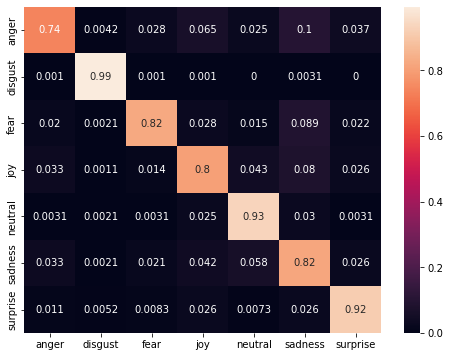

valid:  12%|█▎        | 1/8 [00:03<00:27,  3.99s/it]/apps/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
valid: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


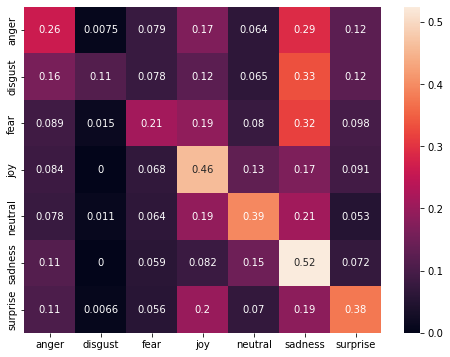

test: 100%|██████████| 9/9 [00:28<00:00,  3.11s/it]


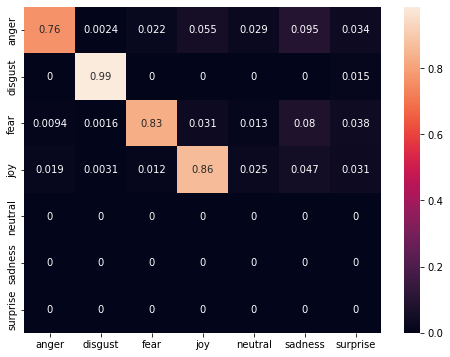

In [130]:
# inference
def inference(model, data_loader, args, prefix='Test'):

    model.eval()

    preds = [] # Logits: [N * 7]
    for feat, label in tqdm(data_loader, desc=prefix, total=len(data_loader)):

        feat, label = feat.to(device), label.to(device)

        with torch.no_grad():
            pred = model(feat)

        preds.append(pd.concat([
            pd.DataFrame(pred.cpu().numpy(), columns=[c for c in data_loader.dataset.classes]),
            pd.DataFrame({'label': label.cpu().numpy()}, index=np.arange(len(label)))
        ],axis=1))

    preds = pd.concat(preds, axis=0)

    return preds

init_state = f'./model/model.bin'
model.load_state_dict(torch.load(init_state, map_location='cpu'))
for name in ['train','valid','test']:
    preds = inference(model, eval(name+"_loader"), None, name)
    pred_class = np.argmax(preds.values[:,:-1],axis=1)
    label = preds["label"]
    arr = pd.DataFrame(
        confusion_matrix(label,pred_class, normalize="true"), 
        index=eval(name+"_loader").dataset.classes, columns=eval(name+"_loader").dataset.classes
    )
    plt.figure(figsize=(8,6))
    sns.heatmap(arr, annot=True)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


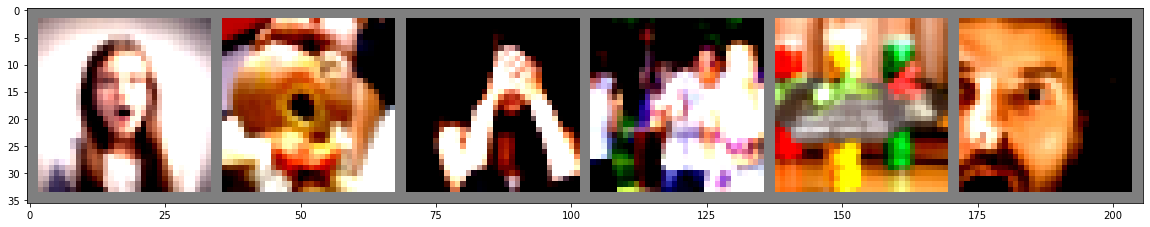

surprise            disgust             sadness             joy                 neutral             surprise            


In [135]:
# visualize
set_seed()
# for 6 images
samples = np.random.choice(len(test_loader.dataset.samples), (6))
samples = [test_loader.dataset[i] for i in samples]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = torch.stack([it[0] for it in samples])
labels = [it[1] for it in samples]

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{test_loader.dataset.classes[labels[j]]:20s}' for j in range(6)))

<AxesSubplot:>

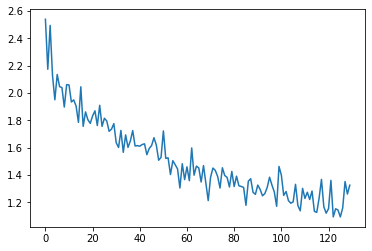

In [10]:
pd.Series(loss_log).plot(title="Train/Running Loss")